In [1]:
# Declaring path variables to make Basemap work in jupyter hub. Make sure that the conda environment path matches yours
import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/share/proj'

In [2]:
# General Tool Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import biota
import biota.plot as bpl
import seaborn as sns
import collections
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import math

from biota.database import (get_samples,
                            get_sample_data,
                            get_pg_connection,
                            get_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
from IPython.core.display import display, HTML
from pickle import dump, load

import lasio

# SQL Query imports
from sqlalchemy import create_engine, engine, inspect

from functools import partial

from ipyparallel import Client
from sourcetracker import gibbs

# Clustering imports
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from skbio.stats.ordination import pcoa

from biota.util import assign_formations


%matplotlib inline

ModuleNotFoundError: No module named 'biota'

In [13]:
#Read in Excel Of Production Data
filename = 'PDX_DAILY_J752801_20190606.xlsm'
xls = pd.read_excel(filename,sheet_name='Test Results',skiprows=10)

#Calculate number of wells (sheets) minus Legend, return wellnames
#len(xls.sheet_names)-1
#wellnames = xls.sheet_names
#del wellnames[0]

#import datetime
#d = datetime.datetime.today()
#currentdate = d.strftime('%d-%m-%Y')

In [65]:
#Old Data For each well#Loop through sheets and create df for each
#Create dictionary of dataframes for each well, map choke values to prod dates in well df
#filename = 'Foraker 1207 Section 11 Lift Dates and Production.xlsx'

oldfilenames = {'1H':'PDX_DAILY_J752801_20190606.xlsm', '2H':'PDX_DAILY_J753701_20190606.xls', '3H':'PDX_DAILY_J753801_20190606.xls',\
            '4H':'PDX_DAILY_K051201_20190606.xls', '5H':'PDX_DAILY_K051301_20190606.xls','6H':'PDX_DAILY_K051401_20190606.xls','7H':'PDX_DAILY_K051501_20190606.xls',\
            '8H':'PDX_DAILY_K051601_20190606.xls','9H':'PDX_DAILY_K051701_20190606.xls','10H':'PDX_DAILY_K051801_20190606.xls','2B':'PDX_DAILY_K051901_20190606.xls',\
            '3B':'PDX_DAILY_K052001_20190606.xls'}
wellnames = ['1H','2H','3H','4H','5H','6H','7H','8H','9H','10H','2B','3B']

In [65]:
dfs = {}
for well in wellnames:
    filename = oldfilenames[well]
    dfs[well] = pd.read_excel(filename, sheet_name='Test Results',skiprows=10)
    dfs[well].rename(columns = {'mm/dd/yy hh:mm':'Date','STB/d' : 'Oil Rate', 'STB/d.1' : 'Water Rate','Mcf/d': 'Gas Rate'},inplace = True)
    dfs[well] = dfs[well][['Date','Oil Rate', 'Water Rate','Gas Rate']].copy()
    dfs[well]['Date'] = pd.to_datetime(dfs[well]['Date']).dt.date
    dfs[well] = dfs[well].drop_duplicates(subset = 'Date', keep ='first').copy()
    #dfs[well].to_pickle("./SavedData/{}.pkl".format(well))

In [87]:
#New Data
newfilenames = {'1H':'SILVERTIP 76-7 UNIT A 1H_BHP DATA.csv', '2H':'SILVERTIP 76-7 UNIT A 2H_BHP DATA.csv', '3H':'SILVERTIP 76-7 UNIT A 3H_BHP DATA.csv',\
            '4H':'SILVERTIP 76-7 UNIT A 4H_BHP DATA.csv', '5H':'SILVERTIP 76-7 UNIT A 5H_BHP DATA.csv','6H':'SILVERTIP 76-7 UNIT A 6H_BHP DATA.csv','7H':'SILVERTIP 76-7 UNIT A 7H_BHP DATA.csv',\
            '8H':'SILVERTIP 76-7 UNIT A 8H_BHP DATA.csv','9H':'SILVERTIP 76-7 UNIT A 9H_BHP DATA.csv','10H':'SILVERTIP 76-7 UNIT A 10H_BHP DATA.csv','2B':'SILVERTIP 76-7 UNIT B 2H_BHP DATA.csv',\
            '3B':'SILVERTIP 76-7 UNIT B 3H_BHP DATA.csv'}

In [85]:
#f = 'SILVERTIP 76-7 UNIT A 1H_BHP DATA.csv'
#df = pd.read_csv(f,skiprows=1)

In [112]:
newdfs = {}
for well in wellnames:
    filename = newfilenames[well]
    newdfs[well] = pd.read_csv(filename,skiprows=1)
    newdfs[well].rename(columns = {'Unnamed: 0':'Date'},inplace = True)
    newdfs[well]['Date'] = pd.to_datetime(newdfs[well]['Date']).dt.date

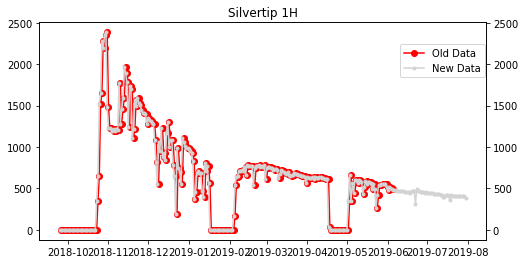

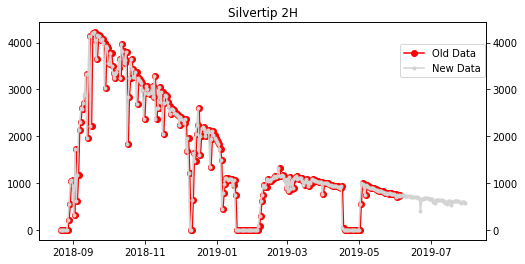

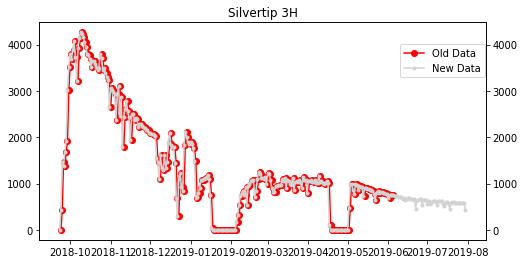

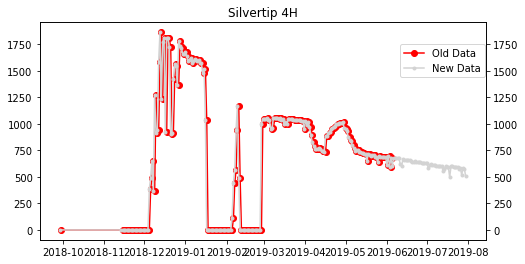

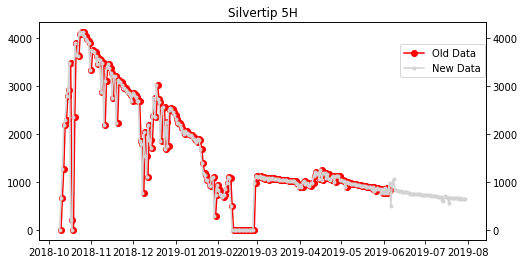

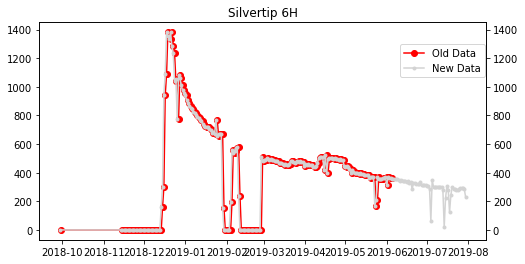

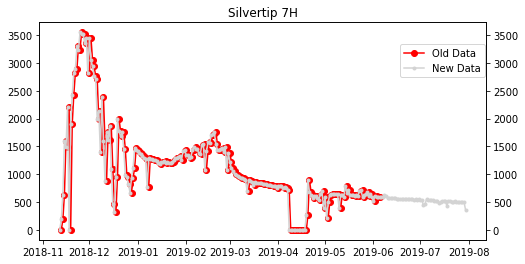

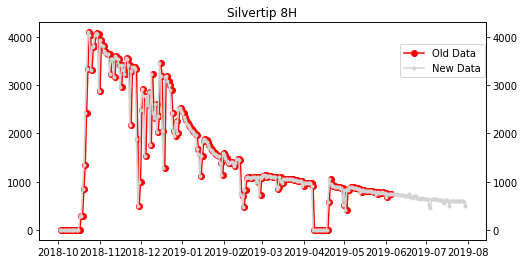

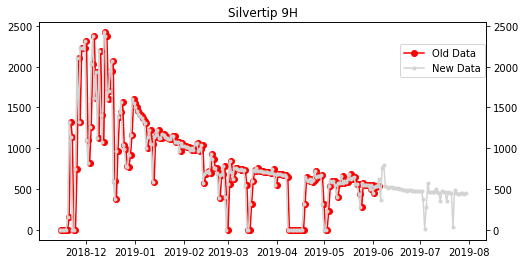

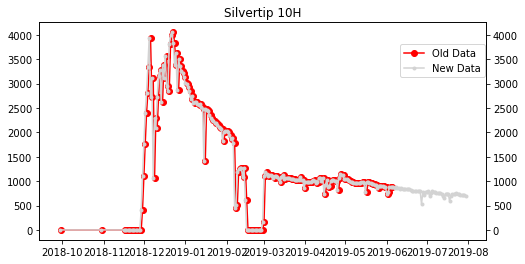

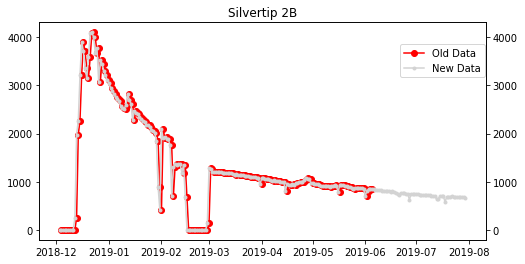

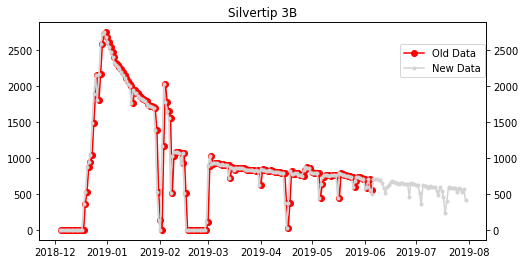

In [131]:
#Loop through wells
for i,well in enumerate(dfs):
    
    fig, axs = plt.subplots(1, figsize=(8,4))
    #Plot Oil Rate
    axs.plot(dfs[well]['Date'],dfs[well]['Oil Rate'],marker='o', c='red', label = 'Old Data')
    ax0 = axs.twinx()
    ax0.plot(newdfs[well]['Date'],newdfs[well]['Oil Rate'],marker='.', c='lightgray', label = 'New Data')
    pad = 'Silvertip '
    wellname = pad + wellnames[i]
    axs.set_title(wellname)
    fig.legend(bbox_to_anchor=(0.35, 0.28, 0.5, 0.5), loc = 'upper right')

In [ ]:
#STB/d = Oil Rate
#STB/d.1 = Water Rate
#Mcf/d = Gas Rate

In [31]:
xls.iloc[24:33,10:25].copy()

,Unnamed: 10,Unnamed: 11,Gas Rate,Mcf,Mcf.1,(scf/STB),Oil Rate,STB/hr,STB,STB.1,Water Rate,STB/hr.1,STB.2,STB.3,STB.4
24,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,644487.97
25,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,644487.97
26,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,644487.97
27,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,644487.97
28,NaN,NaN,1044.410034,0.000000,1044.410034,2992.578894,349.0,14.541667,349.0,349.0,937.0,39.041667,937.0,937.0,643550.97
29,NaN,NaN,1887.119995,1044.410034,1887.119995,2921.238383,646.0,26.916667,995.0,646.0,3363.0,140.125000,4300.0,3363.0,640187.97
30,NaN,NaN,4658.459961,2931.530029,4658.459961,3072.862771,1516.0,63.166667,2511.0,1516.0,5462.0,227.583333,9762.0,5462.0,634725.97
31,NaN,NaN,5271.720215,7589.989990,5271.720215,3181.484740,1657.0,69.041667,4168.0,1657.0,5610.0,233.750000,15372.0,5610.0,629115.97
32,NaN,NaN,7093.750000,12861.710205,7093.750000,3115.393061,2277.0,94.875000,6445.0,2277.0,6622.0,275.916667,21994.0,6622.0,622493.97


In [38]:
xls.rename(columns = {'mm/dd/yy hh:mm':'Date','STB/d' : 'Oil Rate', 'STB/d.1' : 'Water Rate','Mcf/d': 'Gas Rate'},inplace = True)

In [39]:
xls.iloc[24:33,0:5]

,Date,hours,hours.1,1/64ths,psig
24,2018-10-20,24.0,576.0,0.0,0.0
25,2018-10-21,24.0,600.0,0.0,0.0
26,2018-10-22,24.0,624.0,0.0,0.0
27,2018-10-23,24.0,648.0,0.0,0.0
28,2018-10-24,24.0,672.0,20.0,0.0
29,2018-10-25,24.0,696.0,35.0,0.0
30,2018-10-26,24.0,720.0,50.0,0.0
31,2018-10-27,24.0,744.0,58.0,0.0
32,2018-10-28,24.0,768.0,64.0,0.0


In [40]:
shortdf = xls[['Date','Oil Rate', 'Water Rate','Gas Rate']].copy()

In [44]:
dropdf = shortdf.drop_duplicates(subset = 'Date', keep ='first').copy()

In [52]:
dropdf['Date'] = pd.to_datetime(dropdf['Date']).dt.date

In [53]:
dropdf = dropdf.drop_duplicates(subset = 'Date', keep ='first').copy()

In [54]:
dropdf

,Date,Oil Rate,Water Rate,Gas Rate
0,2018-09-26,0.0,0.0,0.000000
1,2018-09-27,0.0,0.0,0.000000
2,2018-09-28,0.0,0.0,0.000000
3,2018-09-29,0.0,0.0,0.000000
4,2018-09-30,0.0,0.0,0.000000
5,2018-10-01,0.0,0.0,0.000000
6,2018-10-02,0.0,0.0,0.000000
7,2018-10-03,0.0,0.0,0.000000
8,2018-10-04,0.0,0.0,0.000000
9,2018-10-05,0.0,0.0,0.000000
